# Stochastic optimization

We study the stochastic optimization by using newsvendor problem:
* Buy x items at cost c
* Items sold at price p
* Salvage price is zero
* Uncertain demand, hence profit is uncertain

The random profit $\pi$ is
$$
p\min\{x,\tilde{d}\} - cx
$$
so that the expected profit is 
$$
p\mathbb{E}[\min\{x,\tilde{d}\}] - cx
$$

### Theoretically solve the newsvendor problem 
Denote $f$ and $F$ as the probability density function and cumulative distribution function of the demand $\tilde{d}$, respectively. We can then express the newsvendor's expected profit as follows:
$$
\pi(x) = p\mathbb{E}[\min\{x,\tilde{d}\}] - cx = p\int_{0}^x f(u) u {\rm d} u +  p\int_{x}^{\infty} f(u) x {\rm d} u - cx. 
$$
(Optional) We then can take the first and second derivative of the function $\pi(x)$:
$$
\frac{{\rm d} \pi(x)}{{\rm d} x} = pxf(x) + p(1 - F(x)) - pxf(x) - c; \frac{{\rm d} \pi^2(x)}{{\rm d} x^2} =  -pf(x) \leq 0.
$$
(Optional) We can see that the function $\pi(x)$ is concave in $x$ and we thus can obtain the maximum of $\pi(x)$ at $x^*$ s.t. 
$$
\frac{{\rm d} \pi(x)}{{\rm d} x} = p(1 - F(x^*)) - c = 0 \Rightarrow x^* = F^{-1}\left( \frac{p-c}{p}\right).
$$

Suppose $p = 10$, $c = 4$, and demand is uniformlly distributed in $[20,100]$, how can we obtain the optimal order quantity? 

What if demand is normally distributed with mean 60 and standard deviation 25? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import rsome as rso
from rsome import ro
from rsome import grb_solver as grb
np.random.seed(3) ##fix the seed for generating random numbers so that numbers generated everytime are the same

In [2]:
from scipy.stats import binom, poisson, norm, uniform, expon, cauchy, lognorm, chi2
## Optimal order quantity (theoretical)
p = 10
c = 4
order_opt_uniform = uniform.ppf( (p - c)/p, 20, 80 )
print( order_opt_uniform )

order_opt_normal = norm.ppf( (p - c)/p, 60, 25 )
print( order_opt_normal )

order_opt_expon = expon.ppf( (p - c)/p, 60 )
print( order_opt_expon )

order_opt_poisson = poisson.ppf( (p - c)/p, 60 )
print( order_opt_poisson )

68.0
66.333677578395
60.916290731874156
62.0


### Solve the newsvendor problem empirically

We know the optimal order quantity for the newsvendor problem, assuming that we know the demand distribution. However, in practice, it's almost impossible to know the true demand distribution. What we usually have are some historical data $\{d_1, d_2, ..., d_K\}$, how can we obtain the order quantity? 

Before that, let's see how can we simulate the demand data if we know the distribution.

In [3]:
K = 5000
D1 = np.random.uniform( 20,100, K )
D2 = np.random.normal( 60,20, K )
D3 = np.random.exponential( 60, K )
D4 = np.random.poisson( 60, K )
Demand_all = np.stack( (D1,D2,D3,D4), axis = 1 )
print(Demand_all.mean(axis = 0), Demand_all.var(axis = 0))

[60.02291943 59.64463729 60.66284695 59.9882    ] [ 529.75484549  398.82563998 3859.45730189   59.95966076]


Now suppose the demand data we obtain is $(D1 + D2)/2$, how to obtain the order quantity? 
* One method is to fit the historical data to some distributions and then derive the order quantity 
* Another method is to obtain the empirical distribution, and derive the order quantity

### Solve the newsvendor model empirically from fitted distribution

(array([  18.,  144.,  506.,  978., 1157., 1044.,  759.,  309.,   77.,
           8.]),
 array([ 13.75208773,  23.40451575,  33.05694377,  42.70937179,
         52.36179981,  62.01422783,  71.66665585,  81.31908387,
         90.97151189, 100.62393991, 110.27636793]),
 <BarContainer object of 10 artists>)

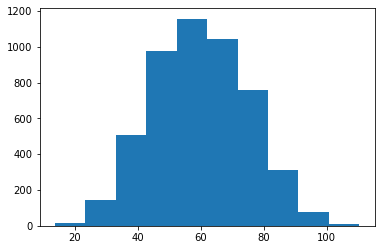

In [4]:
Demand = (D1 + D2)/2
plt.hist(Demand)

Could you help fit the data and obtain the order quantity ``order_emp_fit``?

{'chi2': {'df': 179.4102123976843,
  'loc': -83.59596368857169,
  'scale': 0.7989813615643018}}

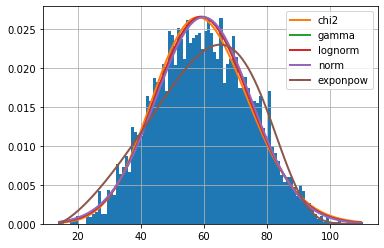

In [5]:
from fitter import Fitter, get_common_distributions, get_distributions
f = Fitter(Demand, distributions=get_common_distributions())
f.fit()
f.summary()

f.get_best(method = 'sumsquare_error')

In [6]:
order_emp_fit = chi2.ppf( (p - c)/p, df = 179.41, loc = -83.59596, scale = 0.7989)
order_emp_fit

63.06232961693736

### Solve the newsvendor model empirically from empirical distribution

We can plot the cdf of the empirical distribution as follows:

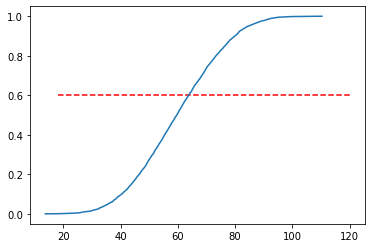

In [7]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(Demand)
plt.plot(ecdf.x, ecdf.y)
plt.hlines((p-c)/p, 18, 120,'r','dashed')
plt.show()

For empirical distribution, basically, we assume each sample has probability $\frac{1}{K}$. As such, we just need to sort the data in ascending order and find the $\frac{p-c}{p}$-th largest value.

Can you obtain the empirical order quantity?

In [8]:
demand_sort = sorted(Demand)
order_emp1 = demand_sort[int(K * (p-c)/p)]
order_emp1

63.73925824436354

### Solve the newsvendor model empirically using RSOME

Alternatively, we can also solve the newsvendor problem directly from data. 

Suppose we have $K$ historical data points $\{d_1, d_2, ..., d_K\}$, we then can empirically solve the newsvendor's problem as follows:
$$
\max_{x \geq 0} \ \frac{1}{K} \sum_{i = 1}^K p \min\{x, d_i\} - cx
$$
which can be equivalently reformulated as a LOP:
$$
\begin{align*}
\max \ & \frac{1}{K} \sum_{i = 1}^K p y_i - cx \\
{\rm s.t.}\  & y_i \leq x & \forall i = 1,...,K\\
&y_i \leq d_i & \forall i = 1,...,K\\  
&x \geq 0 
\end{align*}
$$

Could you help solve this problem using RSOME? You are required to define a function ``Newsvendor_Emp``

In [9]:
def Newsvendor_Emp(p,c,D):
    K = len(D)
    nv = ro.Model('Newsvendor')
    x = nv.dvar()
    y = nv.dvar(K)
    
    nv.max( 1/K*p*y.sum() - c*x )
    nv.st( y <= x,
         y <= D, 
         x >= 0)
    
    nv.solve(grb, display = False)
    return x.get(), nv.get()

In [10]:
def Newsvendor_Emp_NonM(p,c,D):
    K = len(D)
    nv = ro.Model('Newsvendor')
    x = nv.dvar()
    y = nv.dvar(K)
    
    nv.max( 1/K*p*sum(y[i] for i in range(K)) - c*x )
    nv.st( y[i] <= x for i in range(K) )
    nv.st( y[i] <= D[i] for i in range(K) ) 
    nv.st( x >= 0)
    
    nv.solve(grb, display = False)
    return x.get(), nv.get()

In [11]:
p = 10
c = 4
D = (D1 + D2)/2
order_emp2, profit_emp2 = Newsvendor_Emp(p,c,D)
print('The optimal order quantity is:', order_emp2 )
print('-------------------------------------')
print('And the corresponding expected profit is:', profit_emp2 )

Academic license - for non-commercial use only - expires 2022-07-30
Using license file C:\Users\kings\gurobi.lic
The optimal order quantity is: [63.73925824]
-------------------------------------
And the corresponding expected profit is: 299.20365675025045


In [12]:
p = 10
c = 4
D = (D1 + D2)/2
order_emp2, profit_emp2 = Newsvendor_Emp_NonM(p,c,D)
print('The optimal order quantity is:', order_emp2 )
print('-------------------------------------')
print('And the corresponding expected profit is:', profit_emp2 )

The optimal order quantity is: [63.73925824]
-------------------------------------
And the corresponding expected profit is: 299.20365675025045


### Evaluate the solution

We have obtained two order quantities from historical data. But which is better? 

The two solutions can be evaluated by using the newly collected historical data:

``D1 = np.random.uniform( 20,101, 10000 )``

``D2 = np.random.normal( 62,25, 10000 )``

``Demand_test = (D1 + D2)/2``

* Calculate the profit under ``order_emp_fit`` and ``order_emp1`` respectively (denoted as ``profit_emp_fit`` and ``profit_emp``)

* Obtain ``performance_gap`` defined as:

performance_gap = ( profit_emp - profit_emp_fit )/ profit_emp_fit*100

In [13]:
D1 = np.random.uniform( 20,101, 10000 )
D2 = np.random.normal( 62,25, 10000 )
Demand_test = (D1 + D2)/2

Note that the profit for any order quantity x can be obtained via:
    
``Profit = np.mean( p*np.minimum(x, Demand_test) - c*order_emp_fit )``

In [14]:
profit_emp_fit = np.mean( p*np.minimum(order_emp_fit, Demand_test) - c*order_emp_fit )
print( profit_emp_fit )

profit_emp = np.mean( p*np.minimum(order_emp1, Demand_test) - c*order_emp1 )
print( profit_emp )

performance_gap = (profit_emp - profit_emp_fit)/profit_emp_fit*100
print(performance_gap)

300.4272540960051
300.8386893849521
0.13695005474288272


## Multi-item Newsvendor Problem
Now suppose there are $N$ products and $K$ historical samples. Specifically, 
* $N$ items to sell. 
* For each item $i$, unit cost is $𝑐_𝑖$, selling price $𝑝_𝑖$. 
* Order quantity $𝑥_𝑖, i = 1, … , N$. 
* Assume salvage price is zero.
* Each item $i$ incurs storage space $𝑠_𝑖$. Total space available is $C$. 
* $K$ instances of demands available. 
* Let $𝑑_𝑘𝑖$ denotes the demand of item $i$ in instance $k, k = 1, …, K$. 

For this problem, close form solution will be very difficult!

#### A heuristic method
A possible way is to solve the problem heuristically:
* Load the ``Demand_data.csv`` and separate it into training data (70\%) and testing data (30\%)
* Load the ``Param_data.csv`` and obtain the parameters 
* Solve the problem empirically for each product by using the training data
* Rank $\frac{p - c}{p}$ in a descending order (or rank $\frac{p - c}{ps}$ in a descending order)
* Order until space is fully utilized

Could you help obtain the heuristic order quantity ``order_heu``? Suppose the total space $C = 300$

#### Load the demand data

In [15]:
Demand_data = pd.read_csv("Demand_data.csv")
Demand_data.head()

,real_date,prod_1,prod_2,prod_3,prod_4,prod_5,prod_6,prod_7,prod_8,prod_9,prod_10,prod_11,prod_12,prod_13,prod_14,prod_15
0,1/2/2013,99,59,348,47,37,422,67,132,209,28,99,113,70,80,404
1,1/3/2013,80,41,180,34,24,329,47,106,162,27,80,65,49,54,323
2,1/4/2013,73,41,141,33,19,257,55,94,124,26,61,59,36,57,310
3,1/5/2013,103,60,259,38,28,359,66,148,194,28,86,83,66,68,467
4,1/6/2013,109,70,439,46,37,376,63,150,252,33,124,114,77,84,579


#### Separate demand data into training data and test data

In [16]:
from sklearn.model_selection import train_test_split

demand_train, demand_test = train_test_split(Demand_data, test_size=0.3)

#### Load other parameters

In [17]:
Param_data = pd.read_csv("Param_data.csv")
Param_data

,Unnamed: 0,prod_1,prod_2,prod_3,prod_4,prod_5,prod_6,prod_7,prod_8,prod_9,prod_10,prod_11,prod_12,prod_13,prod_14,prod_15
0,Price,10.6,7.3,10.7,9.5,7.6,14.8,10.4,4.7,14.0,6.0,6.1,14.8,11.9,6.9,8.6
1,Cost,3.2,3.9,5.3,3.8,2.1,6.9,5.2,2.9,4.6,2.4,2.4,5.9,3.8,1.7,2.5
2,Space,0.4,0.1,0.4,0.4,0.3,0.3,0.3,0.4,0.4,0.3,0.4,0.1,0.1,0.5,0.2


In [18]:
Demand = np.array( demand_train.values[:,1:16].astype(int) )
K,N = Demand.shape
print(K,N)
price = np.array( Param_data.values[0,1:16].astype(np.float64) )
cost = np.array( Param_data.values[1,1:16].astype(np.float64) )
space = np.array( Param_data.values[2,1:16].astype(np.float64) )
total_space = 300

1175 15


### Obtain ``order_heu``

The solution below HAS NOT ranked $\frac{p-c}{p}$ or $\frac{p-c}{ps}$. Can you try to rank first and obtain the solution? (This is assignment 4, but no need to submit.)

In [22]:
order_heu = []
profit_heu = []
space_heu = []
for i in range(N):
    order, profit = Newsvendor_Emp(price[i],cost[i],Demand[:,i])
    space_heu.append( space[i]*order[0] )
    if sum(space_heu) <= total_space:
        order_heu.append( order[0] )
        profit_heu.append( profit )
    else:
        surplus = total_space - sum(space_heu[0:-1])
        space_heu[i] = max(surplus,0)
        
        order = max( surplus/space[i], 0)
        profit = np.mean( price[i]*np.minimum(order, Demand[:,i]) - cost[i]*order )
        order_heu.append( order )
        profit_heu.append( profit )
    
print( order_heu )
print( sum( profit_heu ) )

[68.0, 47.0, 109.0, 45.0, 38.0, 234.0, 60.0, 54.0, 121.0, 33.0, 67.5, 0.0, 0.0, 0.0, 0.0]
4261.445148936156


### Solve the problem empirically by using RSOME

Alternatively, this problem can be solved by using the following model:
$$
\begin{align*}
\max \ &\sum_{i = 1}^N\left( \frac{1}{K} \sum_{k = 1}^K p_i t_{ki} - c_i x_i \right) \\
{\rm s.t.}\  & t_{ki} \leq x_i & \forall i = 1,...,N, k = 1,...,K\\
&t_{ki} \leq d_{ki} & \forall i = 1,...,N, k = i,...,K\\  
&\sum_{i = 1}^N s_i x_i \leq C\\
&x_i \geq 0 & \forall i = 1,...,N 
\end{align*}
$$

Could you help solve this problem using RSOME? You are required to define a function ``Multi_Newsvendor_Emp``

In [19]:
def Multi_Newsvendor_Emp(p,c,D,s,C):
    K,N = D.shape
    
    mnv = ro.Model('Multi_Newsvendor')
    x = mnv.dvar(N)
    t = mnv.dvar( (K,N) )
    
    mnv.max( 1/K*( (t @ p).sum() ) - c @ x )
    
    mnv.st( t[:,i] <= x[i] for i in range(N) )
    mnv.st( t <= D )
    mnv.st( s @ x <= C )
    mnv.st( x >= 0)
    
    mnv.solve(grb, display = True)
    return x.get(), mnv.get()

In [20]:
order_emp, profit_emp = Multi_Newsvendor_Emp(price,cost,Demand,space,total_space)
print('The optimal order quantity is:', order_emp )
print('-------------------------------------')
print('And the corresponding expected profit is:', profit_emp )

Being solved by Gurobi...
Solution status: 2
Running time: 0.0818s
The optimal order quantity is: [ 54.          42.          71.          34.          29.
 207.          48.66666667   0.          93.          25.
  74.          55.          73.          27.         231.        ]
-------------------------------------
And the corresponding expected profit is: 5975.237815601608


### Evaluate the two solutions ``order_heu`` and ``order_emp`` by using testing data

Note that the profit for any order quantity x can be obtained via:
    
``Profit = np.mean( np.minimum(x @ price, Demand_test @ price) - cost @ x )``

In [23]:
## Optimal order quantity (theoretical)
Demand_test = np.array( demand_test.values[:,1:16].astype(int) )

profit_heu = np.mean( np.minimum(order_heu @ price, Demand_test @ price) - cost @ order_heu )
print( profit_heu )

profit_emp = np.mean( np.minimum(price @ order_emp, Demand_test @ price) - cost @ order_emp )
print( profit_emp )

Performance_imp = (profit_emp - profit_heu)/profit_heu*100
print( Performance_imp )

5434.85763888889
6669.300529100529
22.71343560829702
